# satCORPS composite Sketch #3 STARE Sorted Subsetting & ROI Coarsening

![Subsetting STARE-sorted format data](2022-0519-STARE-sorted-ScatterPlot-Resolution\=11.jpg)


In [1]:
import sys
sys.path.insert(0,'/homelocal/mrilee/git/pystareplotlib')

import os
os.environ['PROJ_LIB'] = '/homelocal/mrilee/opt/anaconda3/envs/stare-1/share/proj'

import pystare
import starepandas
import geopandas
import pandas

import numpy
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

import pystareplotlib
import pystareplotlib.pystareplotlib as psplot

import datetime
import time

import pickle

import regionmask
import xarray
from shapely.geometry import Polygon

import dask

plot_options = {'projection': ccrs.PlateCarree(central_longitude=0.0)
                ,'transform': ccrs.Geodetic()}

In [2]:
class timings_store:
    def __init__(self):
        self.timings = {}
        return
   
    def add(self,key,value,verbose=True):
        self.timings[key] = value
        if verbose:
            print("{} {}".format(key,value))
        return self
    
    def print_report(self,fmt="{:30} {:>6.2f}",key=None,grepv=None):
        for i, (k,v) in enumerate(self.timings.items()):
            if key is None:
                if not grepv is None:
                    if not grepv in k:
                        print(fmt.format(k,v.total_seconds()))
                else:
                    print(fmt.format(k,v.total_seconds()))
            else:
                if key in k:
                    if not grepv is None:
                        if not grepv in k:
                            print(fmt.format(k,v.total_seconds()))
                    else:
                        print(fmt.format(k,v.total_seconds()))
        return self
    
timings = timings_store()

In [3]:
if False:
    s0 = datetime.datetime.now()
    time.sleep(1.5)
    timings.add('a',datetime.datetime.now()-s0)
    time.sleep(15)
    timings.add('b',datetime.datetime.now()-s0)
    timings.print_report(fmt='{:30} {:>6.2f}')
    timings.print_report(fmt='{:5}:{:>6.2f}')
    timings.print_report()

In [4]:
if False:
    timings.print_report()
    timings.print_report(key='a')
    timings.print_report(grepv='b')

## Define our prototype STARE-sorted format data loader

In [5]:
# take the intersection, get the level, coerce to it, then uniquify, then loop, load, and concat.

class chunk_lite:
    def __init__(self,start,stop):
        self.start = start
        self.stop  = stop
        return
    
def read_hdf(data_filename,sids,pods_map_filename):
    pods_map_filename = 'pods_map.pkl' if pods_map_filename is None else pods_map_filename
    
    start1 = datetime.datetime.now()
    with open( pods_map_filename, 'rb' ) as f:
        pods_lite = pickle.load(f)
    # timings.add('time to load pods map',datetime.datetime.now() - start1)
    
    resolution = int(pystare.spatial_resolution(list(pods_lite.keys())[0]))
    
    idx = numpy.unique(
        pystare.spatial_clear_to_resolution(
            pystare.spatial_coerce_resolution(pystare.expand_intervals(sids,resolution),resolution)))
                                              
    # print(idx)
    dfs = []
    for s in idx:
        chunk = pods_lite[s]
        df = pandas.read_hdf(data_filename,start=chunk.start+2,stop=chunk.stop)
        dfs.append(df)
        
    return pandas.concat(dfs)

## Load the ROI

In [6]:
start0 = datetime.datetime.now()
with open( 'ROI.pkl', 'rb' ) as f:
    roi = pickle.load(f)
timings.add('time to load ROI',datetime.datetime.now() - start0)

time to load ROI 0:00:00.043228


## Use the ROI to load data from the sorted STARE-format data file

- Optionally coarsen the resolution of the ROI

## Take a look at the data loaded

In [7]:
plot_options = {'projection': ccrs.PlateCarree(central_longitude=0.0)
                ,'transform': ccrs.Geodetic()}
plot_options['projection']._threshold = 0.01

In [8]:
if False:
    usr_figax = psplot.FigAxContainer(
        plt.subplots(figsize=(4,4), dpi=400
                            ,subplot_kw=plot_options))

    usr_figax.ax.gridlines(linewidth=0.1)
    usr_figax.ax.set_global()
    usr_figax.ax.coastlines(linewidth=0.1)

    usr_figax, sivs_cache, sivs_triang = psplot.hello_plot(b,usr_figax,rasterized=True,plot_options=plot_options)
    del usr_figax, sivs_cache, sivs_triang

time to change resolution, mask, and read ql=11 0:00:04.208670


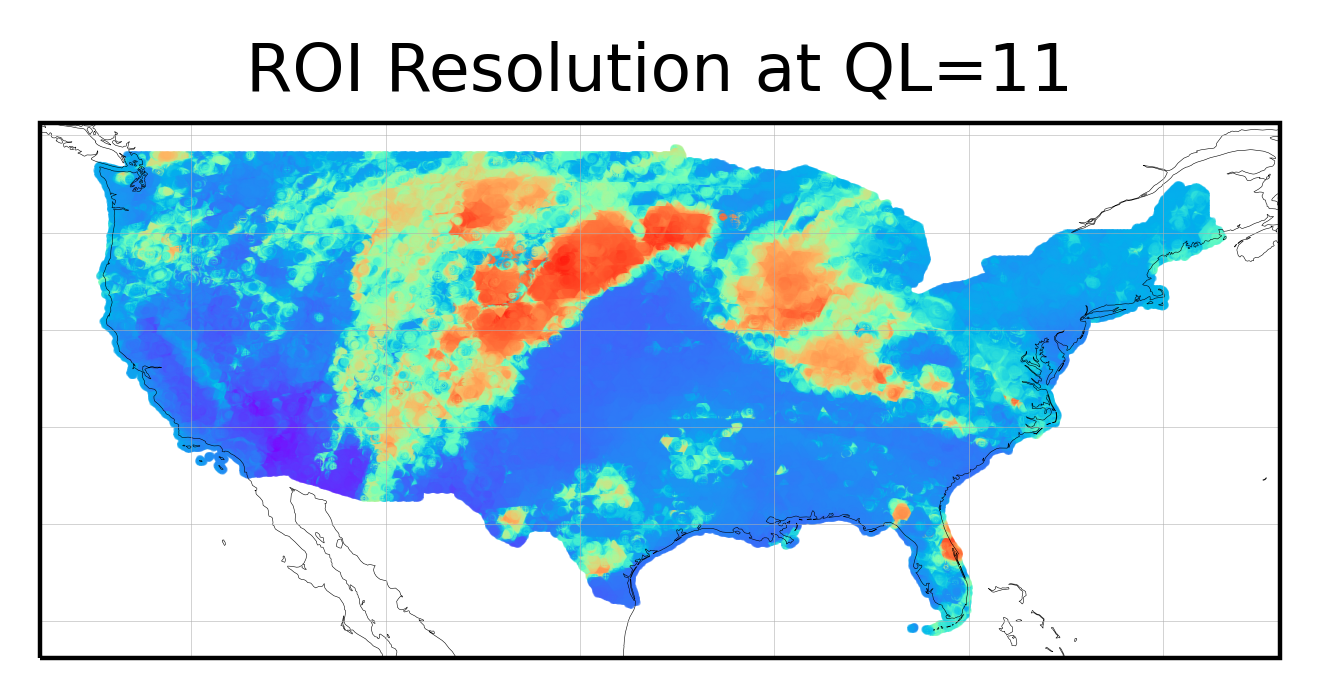

loop at resolution 11 end 0:00:08.637949
time to change resolution, mask, and read ql=9 0:00:03.981778


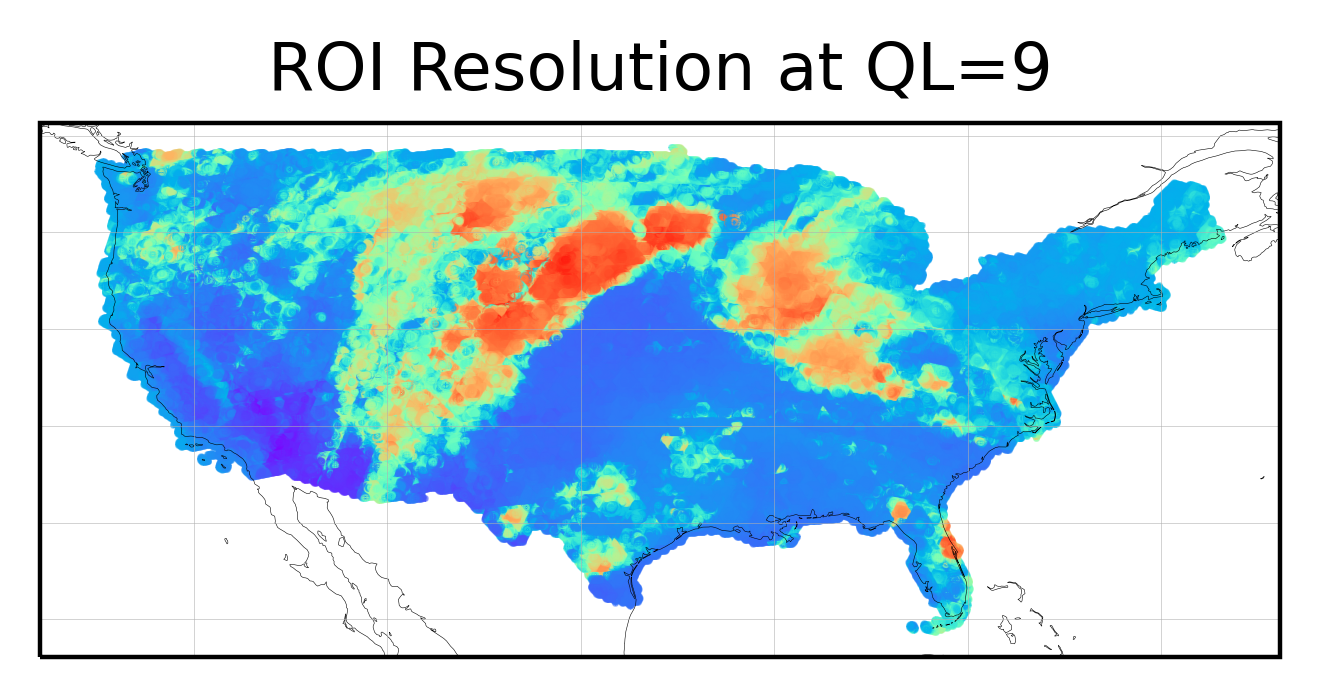

loop at resolution 9 end 0:00:16.948517
time to change resolution, mask, and read ql=7 0:00:03.919289


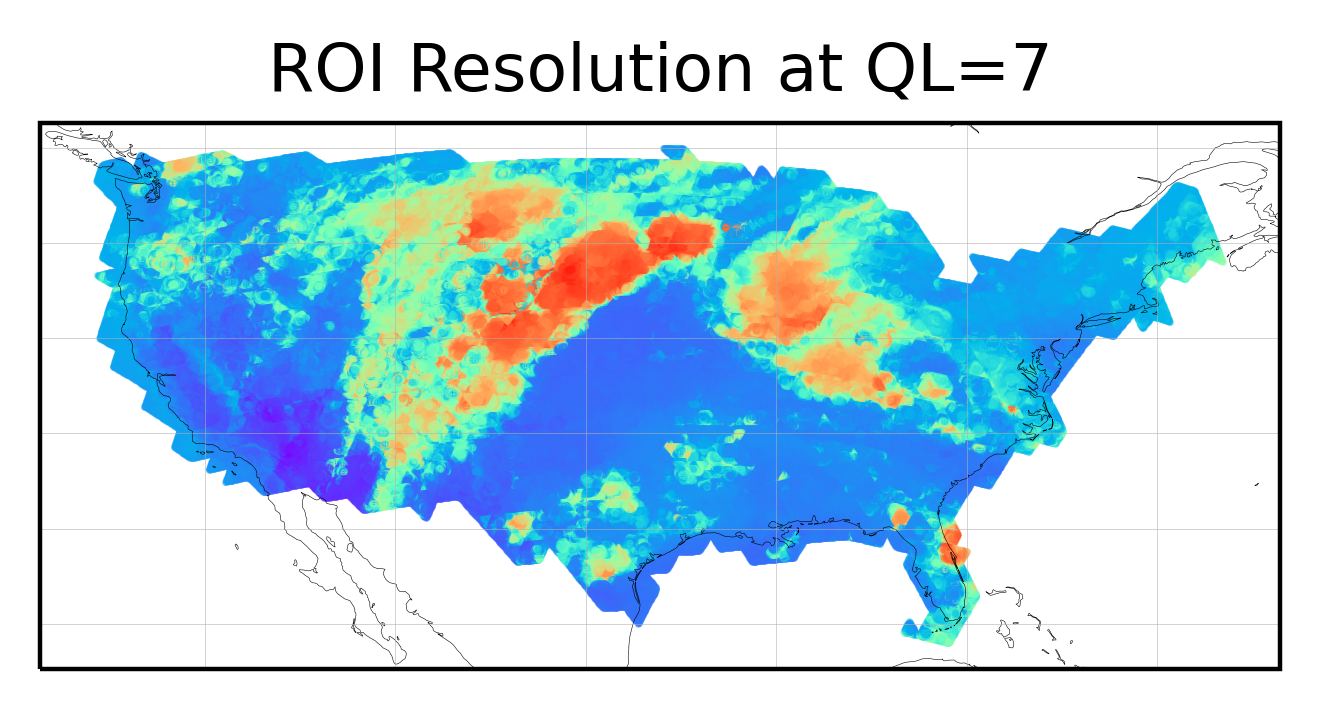

loop at resolution 7 end 0:00:25.398331
time to change resolution, mask, and read ql=5 0:00:03.834106


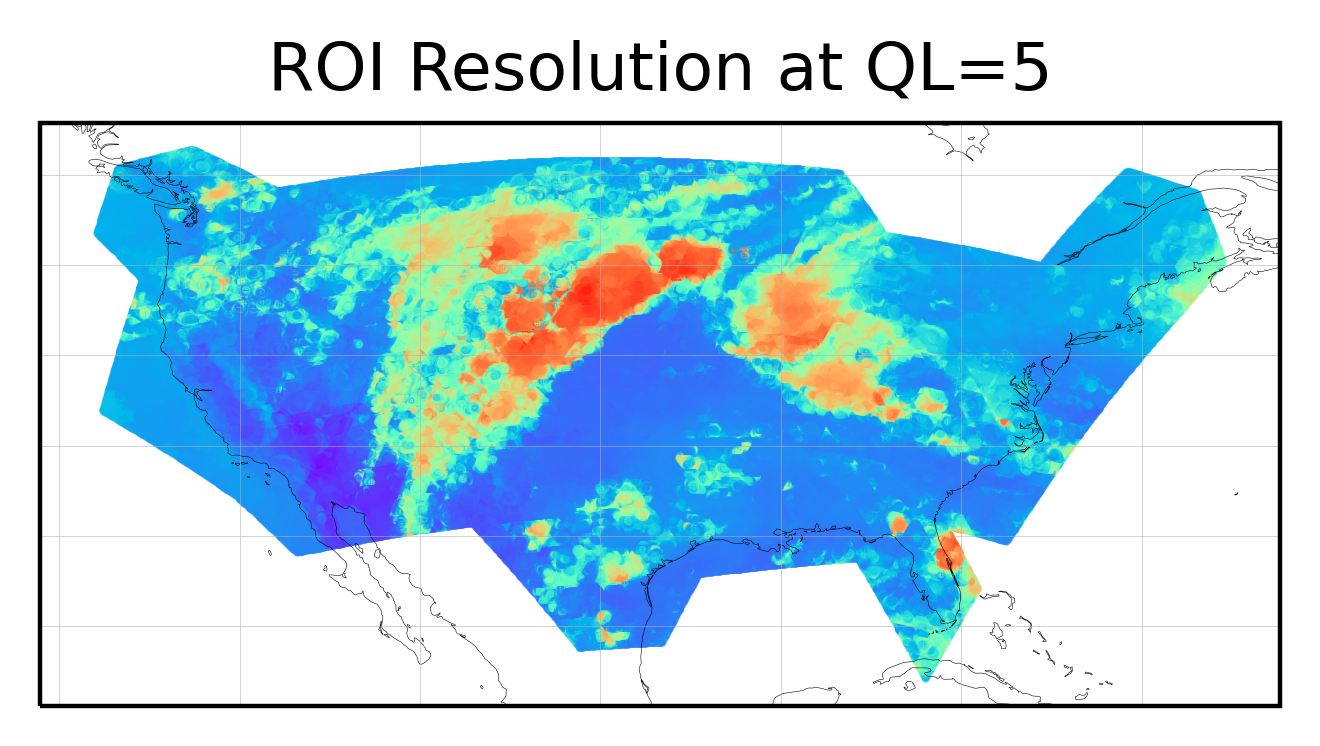

loop at resolution 5 end 0:00:35.546645
time to change resolution, mask, and read ql=3 0:00:05.217669


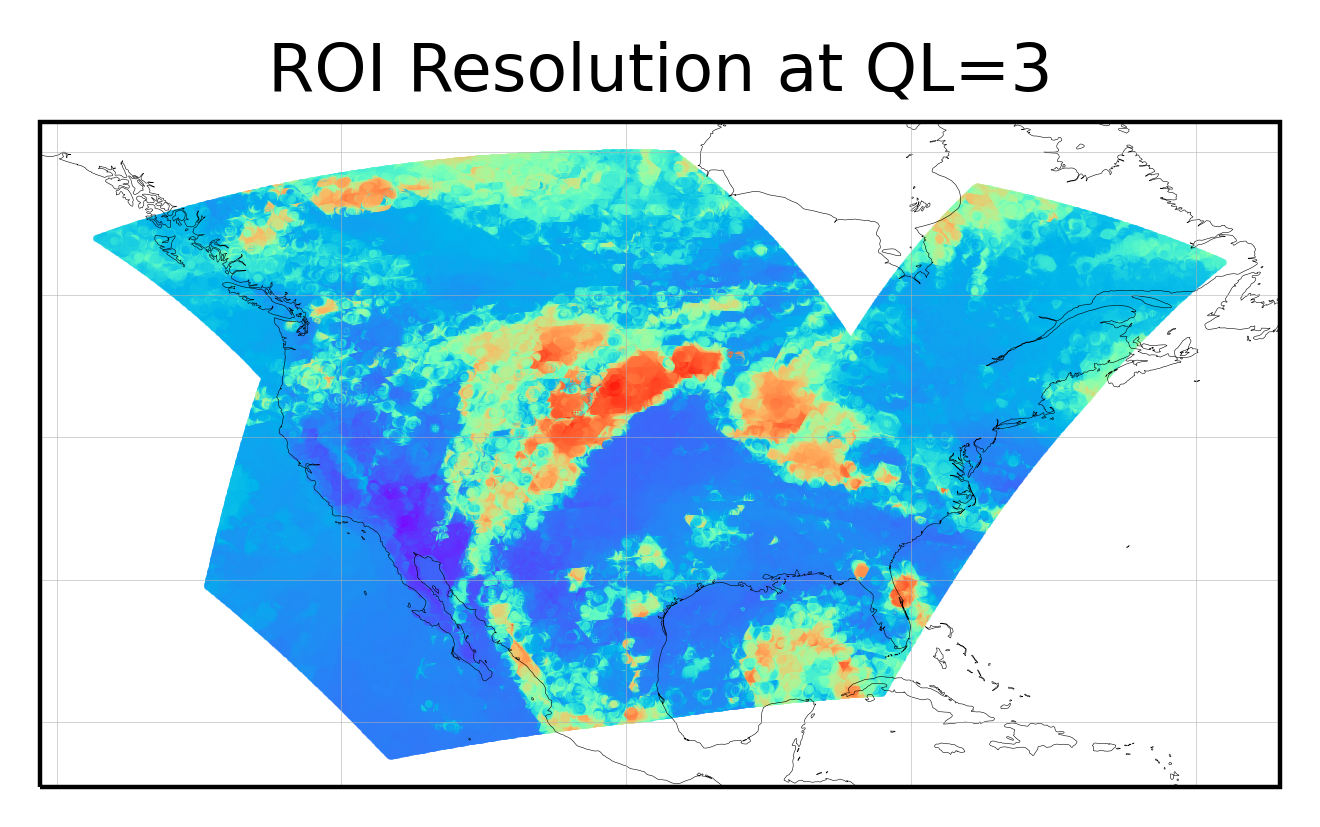

loop at resolution 3 end 0:00:51.019026
time to change resolution, mask, and read ql=1 0:00:09.488193


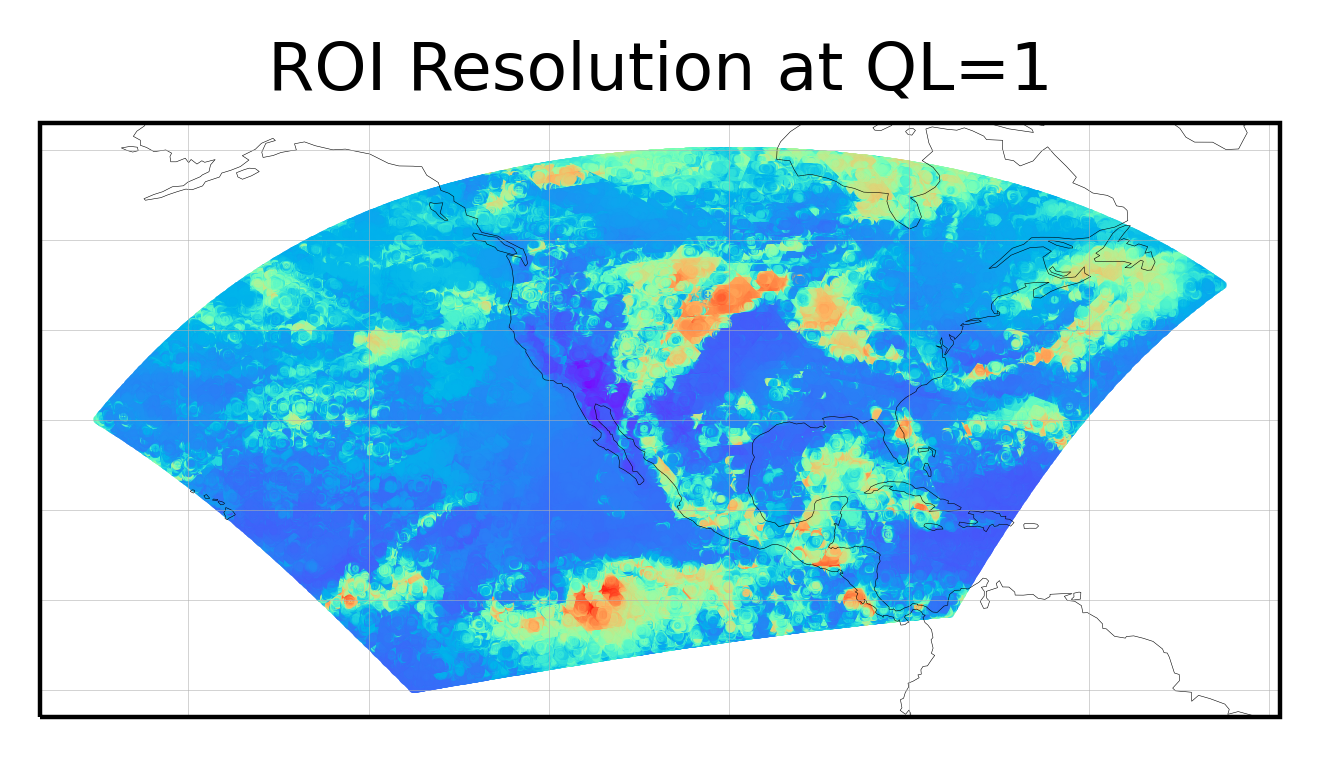

loop at resolution 1 end 0:01:22.858689
time to change resolution, mask, and read ql=0 0:00:10.928388


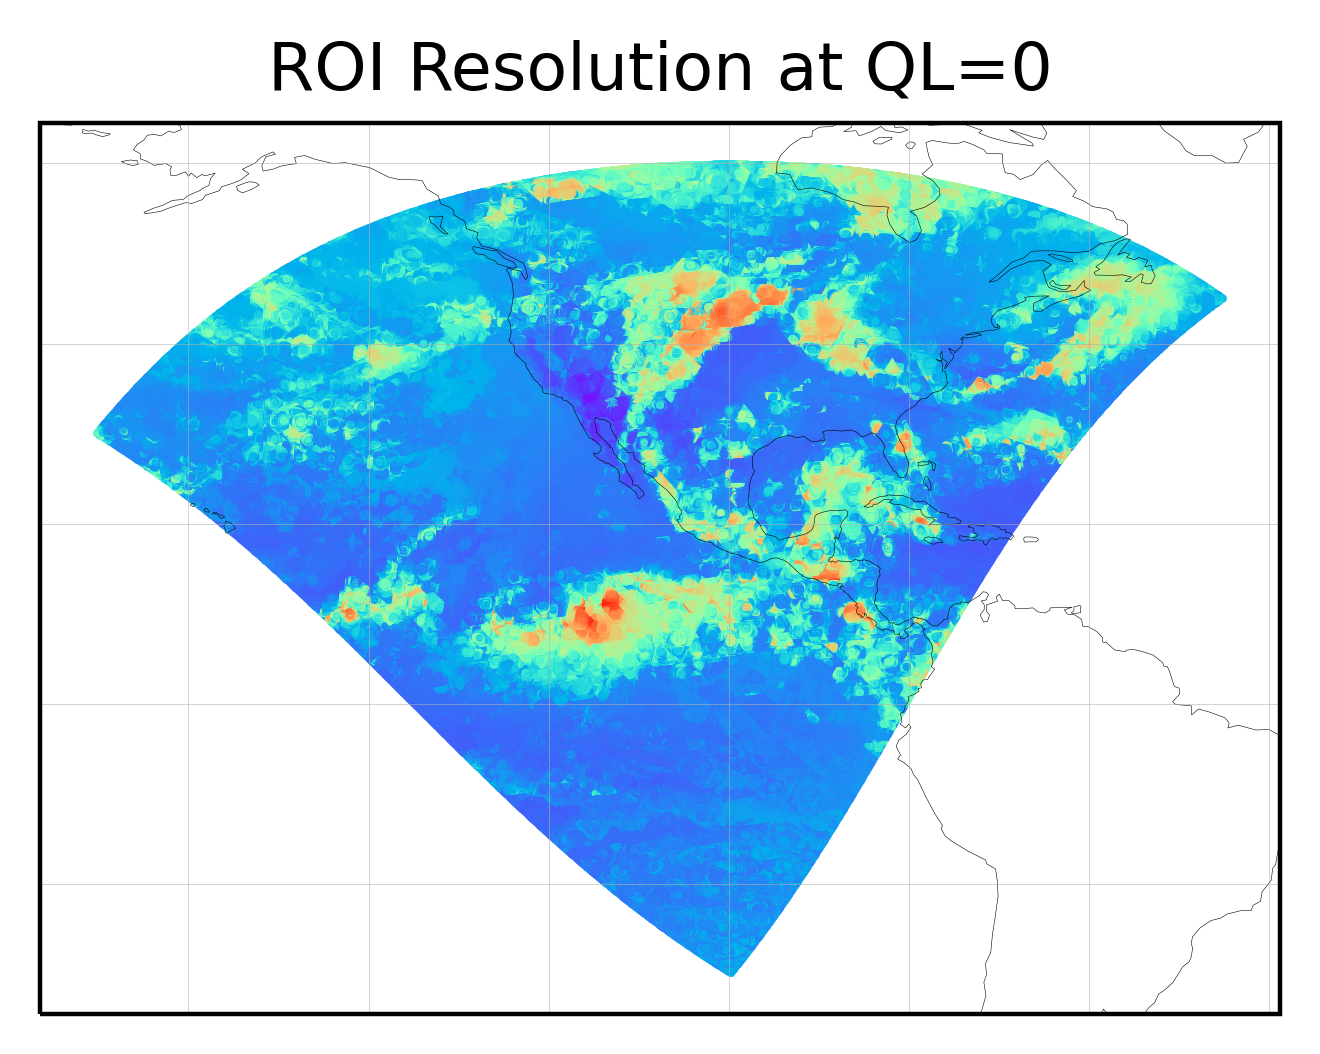

loop at resolution 0 end 0:02:01.651991


In [9]:
start0 = datetime.datetime.now()

# for resolution in [11,10,9,8,7,6,5,4,3,2,1,0]:
for resolution in [11,9,7,5,3,1,0]:
# for resolution in [3]:
    
    start1 = datetime.datetime.now()
    
    # timings.add('loop at resolution %s start at'%resolution,datetime.datetime.now()-start1)

    b = roi['sids'].iloc[:].to_numpy().copy()

    # Set resolution of ROI to load
    if True:
        # resolution = 3
        # Description
        #
        #   Where the neighborhood is finer than the resolution
        #   extract the location from the HTM id, set the
        #   resolution to the desired resolution and clear the
        #   location/tree information finer than that resolution.
        #   Afterwards, eliminate redundant ids.
        #
        b[ (b & 31) > resolution ] = \
            pystare.spatial_clear_to_resolution(
                ( b[ (b & 31) > resolution ] & ~31 ) | resolution )
        b = numpy.unique(b)

    df = starepandas.STAREDataFrame(read_hdf('composite.h5',b,'pods_map.pkl')).reset_index()
    c = df.stare_intersects(b,n_workers=50)
    df = df[c]

    timings.add('time to change resolution, mask, and read ql=%s'%resolution
                ,datetime.datetime.now()-start1)

    usr_figax = psplot.FigAxContainer(
        plt.subplots(figsize=(4,4), dpi=400
                     ,subplot_kw=plot_options))

    plt.title('ROI Resolution at QL=%s'%resolution)
    ax = usr_figax.ax

    usr_figax.ax.gridlines(linewidth=0.1)
    # usr_figax.ax.set_global()
    usr_figax.ax.coastlines(linewidth=0.1)

    if False:
        # x0 = 166; y0 = -15; dlim = 0.5
        # x0 = 165.5; y0 = -17.5; dlim = 3.75
        # dlimx = dlim; dlimy = dlim
        x0 = -127; y0 = 24; dlimx = 61; dlimy = 27
    
        ax.set_xlim(x0,x0+dlimx)
        ax.set_ylim(y0,y0+dlimy)

        marker_size=40.0/(dlim**2) # good for 'o'
        marker_size=27.0/(dlim**2) # good for 's'
        marker_alpha=0.5
    else:
        ax.set_aspect('equal')
        marker_size=0.01
        marker_alpha=0.5
    
    marker='s'

    # df.plot(ax=ax,column='map_data/BT_12.0m',zorder=1,cmap='OrRd',trixels=True)
    # df.plot(ax=ax,zorder=1,color='red',trixels=False,boundary=True)

    # Doesn't work for 1-D data
    # ax.contourf(df['lons'],df['lats'],df['BT_12_0um']
    #            ,cmap='nipy_spectral'
    #            ,cmap='rainbow'
    #            ,transform=ccrs.PlateCarree()
    #        )
    if True:
        usr_figax.ax.scatter(df['lons'],df['lats']
                    ,s=marker_size
                    ,c=df['BT_12_0um']
                    ,alpha=marker_alpha
        #            ,cmap='nipy_spectral'
                    ,cmap='rainbow_r'
                    ,marker=marker
                    ,rasterized=True
                    ,transform=ccrs.PlateCarree()
                    )

    
    
# bdf = starepandas.STAREDataFrame(sids=b,add_trixels=True)
# bdf.plot(
#     ax=ax
#     ,trixels=True, boundary=True, color='y', zorder=1, linewidth=0.5
#     ,transform=ccrs.PlateCarree()
# )

    if False:
        usr_figax, sivs_cache, sivs_triang = psplot.hello_plot(b,usr_figax
                                                                ,rasterized=True
                                                                ,face_edgecolors='r'
                                                                ,show_fig=False
                                                              )
        del sivs_cache, sivs_triang

# plt.scatter(df['lons'],jdf1['lats'],s=marker_size,color='k',alpha=marker_alpha)
# plt.scatter(df['lons'],jdf1['lats'],s=marker_size,color='k',alpha=marker_alpha)

    if False:
        # bdf.plot(ax=ax, trixels=True, boundary=True, color='k', zorder=1, linewidth=0.25)
        roi.plot(ax=ax, trixels=True, boundary=True, color='k', zorder=1, linewidth=0.5)
    
    if False:
        conus1.plot(ax=ax, trixels=False, facecolor="none", edgecolor='yellow', zorder=1, linewidth=1.5)
    
    plt.show()
    del usr_figax, ax

    timings.add('loop at resolution %s end'%resolution,datetime.datetime.now()-start0)

In [10]:
timings.add('total time to read & render',datetime.datetime.now() - start0)

total time to read & render 0:02:01.659542


## Timing summary report

In [11]:
timings.print_report(fmt="{:50} {:>6.2f}",key='mask')

time to change resolution, mask, and read ql=11      4.21
time to change resolution, mask, and read ql=9       3.98
time to change resolution, mask, and read ql=7       3.92
time to change resolution, mask, and read ql=5       3.83
time to change resolution, mask, and read ql=3       5.22
time to change resolution, mask, and read ql=1       9.49
time to change resolution, mask, and read ql=0      10.93


In [12]:
timings.print_report(fmt="{:50} {:>6.2f}",key='end')

loop at resolution 11 end                            8.64
loop at resolution 9 end                            16.95
loop at resolution 7 end                            25.40
loop at resolution 5 end                            35.55
loop at resolution 3 end                            51.02
loop at resolution 1 end                            82.86
loop at resolution 0 end                           121.65
total time to read & render                        121.66
